### Fill out:
Name & Surname: DENG YUXUAN

Student ID: 34254900

## W9&W10 post studio exercises (Logistic regression, Decision trees)

Enter your solution in the cell(s) below each exercise. Add couple of inline comments explaining your code. Don't forget to add comments in markdown cell after each exercise. Missing comments (in markdown cells and/or inline) and late submissions will incur penalties.

Once done, drag&drop your python file to your ADS1002-name github account.

Copy url of this file on github to appropriate folder on Moodle by 09.30am prior your next studio. 

Solutions will be released later in the semester.

Max 10 marks - 2.5 marks per each exercise.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

## Exercises (Logistic regression)

In this exercise you are going to construct a simple one vs rest multiclass classifier based on the probabilities for each of the binary problems for the three iris species. A one-vs-rest classification scheme constructs multiple models (one for each class) where each model predicts a binary classification and combines the results to come up with a single prediction.

For this problem, only use the first two features, i.e., `sepal length` and `sepal width` (don't standardise/normalise/etc). 

The steps for this multiclass classifier are:

* Exercise 1: 
    * Create a new features dataframe which contains only the first two columns of the iris data frame. 
    * For each of the iris categories, i.e., species_setosa, species_versicolor, and species_virginica, model the data using Logistic Regression and calculate the probabilities for the testing set of the category being correct. Store these probabilites in an array (or dataframe). For each category you will need to re-do the train-test split, but make sure you use the same random state (random state 1). Alternatively, split the data set initially with all three labels, and then work on each category. The necessary one-hot encoding has already been performed.
    * **Settings:**
        * 80/20 train-test-split with random state = 1
        * **LogisticRegression()** (meaning default solver and penalty applies)
    * **Output:** Show first 5 (rows of) probabilities for all (3) species.
* Exercise 2: 
    * For each instance in feature space (testing set), choose the category with the highest probability. The function `numpy.argmax()` will be useful.     
    * **Output:** Show first 5 entries for sepal_length, sepal_width, max probability and predicted class.
    * **Output:** Plot the final classification for the testing set in feature space, with colours based on the predicted category.
    
**Exercises 1 - 2** below correspond to the two points outlined above.

Q: After completing the code below and inspecting the results, comment on which class(es) appear most difficult to predict accurately. Can you suggest any improvements to the model which might result in better accuracy?

In [41]:
iris = sns.load_dataset('iris') # load the dataset from seaborn

species_one_hots =  pd.get_dummies(iris.species, prefix = 'species')
iris = pd.concat([iris, species_one_hots], axis = 1)

### Exercise 1

In [42]:
# Part 1
# Create a new features dataframe with only the first two columns
features = iris[['sepal_length', 'sepal_width']]
labels = species_one_hots  # One-hot encoded labels

# Initialize an empty DataFrame to store probabilities
probabilities = pd.DataFrame()

# Set random state for reproducibility
random_state = 1

# fit a logistic model
for species in ['species_setosa', 'species_versicolor', 'species_virginica']:
    # Split the data into 80/20
    X_train, X_test, y_train, y_test = train_test_split(features, labels[species], test_size=0.2, random_state=random_state)
    
    # Create and fit the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Predict probabilities for the test set
    prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    probabilities[species] = prob  # Store in the DataFrame

# Display the first 5 rows of probabilities for all species
probabilities.head()

,species_setosa,species_versicolor,species_virginica
0,0.742914,0.040603,0.225749
1,0.302666,0.519712,0.099330
2,0.013205,0.307877,0.678468
3,0.889100,0.047435,0.116070
4,0.001814,0.083273,0.960356


### Exercise 2

In [43]:
# Part 2
predicted_classes = probabilities.idxmax(axis=1)  # Get the species with the highest probability
max_probabilities = probabilities.max(axis=1)# Get the maximum probabilities

# Combine the testing set with predicted results
results = pd.DataFrame(X_test.reset_index(drop=True))
results['max_probability'] = max_probabilities
results['predicted_class'] = predicted_classes

# Display the first 5 entries
results.head()



,sepal_length,sepal_width,max_probability,predicted_class
0,5.8,4.0,0.742914,species_setosa
1,5.1,2.5,0.519712,species_versicolor
2,6.6,3.0,0.678468,species_virginica
3,5.4,3.9,0.889100,species_setosa
4,7.9,3.8,0.960356,species_virginica


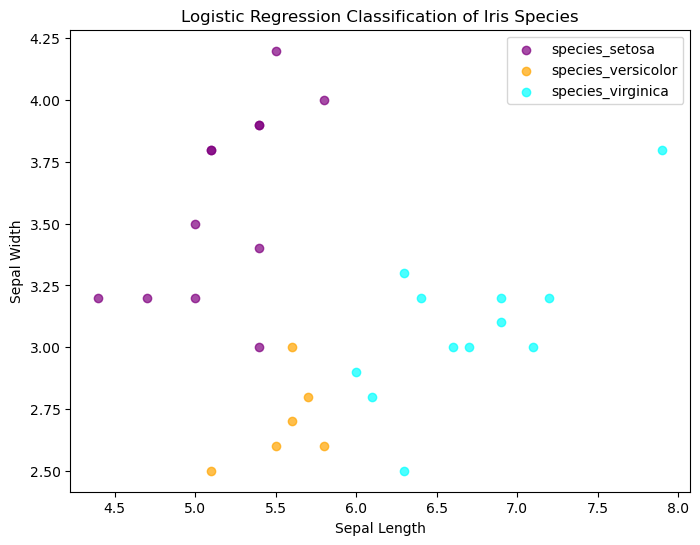

In [28]:
# define colour map before plotting
colour_map = {
    'species_setosa': 'purple',
    'species_versicolor': 'orange',
    'species_virginica': 'cyan'
}

results['colour'] = results['predicted_class'].map(colour_map)

# plot final classification
plt.figure(figsize=(8, 6))
for species, colour in colour_map.items():
    subset = results[results['predicted_class'] == species]
    plt.scatter(subset['sepal_length'], subset['sepal_width'],
                c=colour, label=species, alpha=0.7)

plt.title('Logistic Regression Classification of Iris Species')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.show()


## Exercises (Decision trees)

For these exercises we will model a dataset of the properties of wheat seeds, which you can download from GitLab: 

[seeds_dataset](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Supervised-Methods/Decision-Trees/seeds_dataset.csv)

This is originally from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/seeds). The seedtype is an integer (1, 2, or 3) corresponding to the three classes `Kama`, `Rosa` and `Canadian` in the classes list below.

Run all the cells below before writing your solutions; don't standardise/normalise/etc.

In [44]:
seeds = pd.read_csv('seeds_dataset.csv', header=None, 
                   names=['area','perimeter','compactness','length','width','asymmetry',
                         'groovelength','seedtype'])
classes = ['Kama', 'Rosa', 'Canadian']

In [31]:
seeds.head()

,area,perimeter,compactness,length,width,asymmetry,groovelength,seedtype
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Split the data into features and labels, and into a training and testing set.

In [45]:
X_ex = seeds.drop('seedtype', axis = 1)
y_ex = seeds['seedtype']

X_train, X_test, y_train, y_test = train_test_split(
    X_ex, y_ex, random_state = 42
)

### Exercise 3

Create a simple Decision Tree of maximum depth=3 and fit the training data to this model.

**Settings for decision tree:**

* random state 42
* max depth 3

Plot the decision tree for this model, and identify the most significant features for the classification of this dataset.

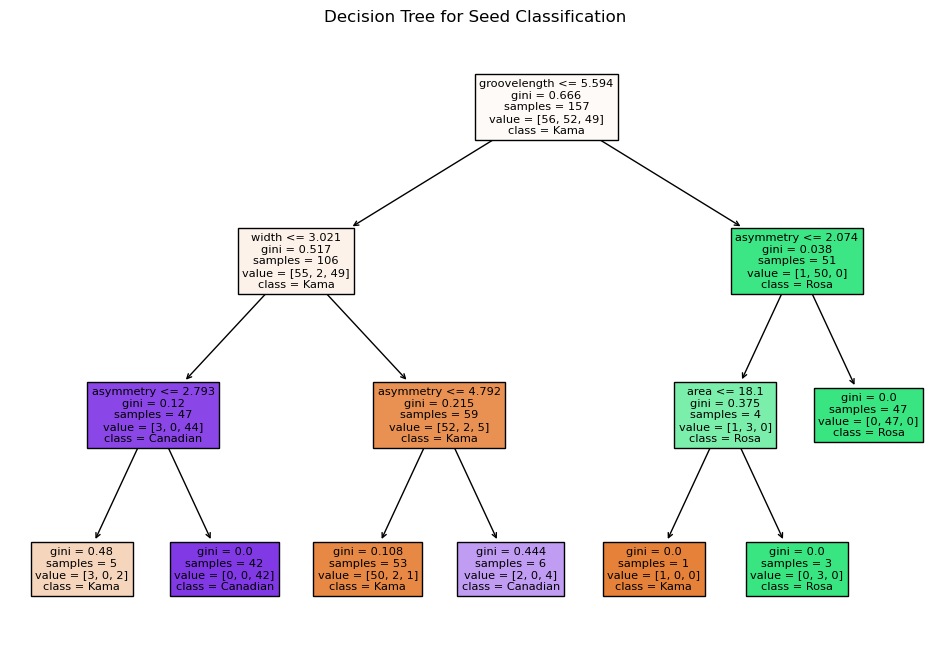

Feature: area, Importance: 0.01600733547172018
Feature: perimeter, Importance: 0.0
Feature: compactness, Importance: 0.0
Feature: length, Importance: 0.0
Feature: width, Importance: 0.3892834321056462
Feature: asymmetry, Importance: 0.08487362425611568
Feature: groovelength, Importance: 0.509835608166518


In [46]:
# Create a DecisionTreeClassifier with max depth of 3 and random state 42
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)

# Fit the model to the training data
decision_tree.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, feature_names=list(X_train.columns), class_names=classes, filled=True)
plt.title('Decision Tree for Seed Classification')
plt.show()

# Identify the most significant features
importances = decision_tree.feature_importances_
for feature, importance in zip(X_train.columns, importances):
    print(f"Feature: {feature}, Importance: {importance}")

### Exercise 4

Plot the confusion matrix for this model, and calculate the accuracy.

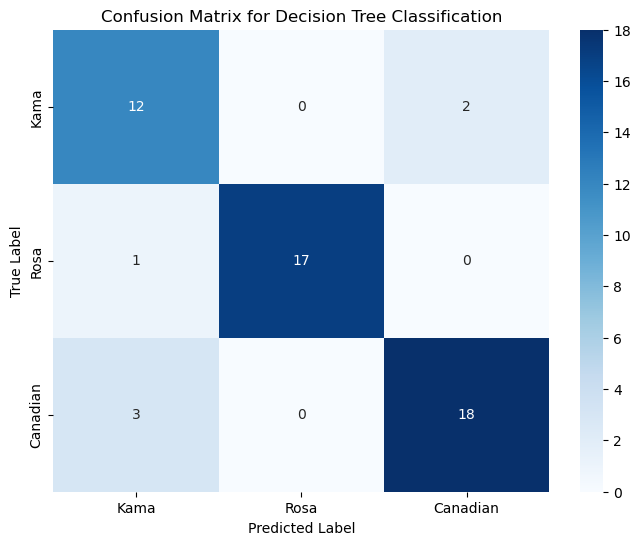

Accuracy of the Decision Tree model: 88.68%


In [47]:
# Predict the labels for the test set
y_pred = decision_tree.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Decision Tree Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Decision Tree model: {accuracy * 100:.2f}%')